# Математические пакеты

## Лабораторная работа №1: Основы цифровой обработки сигналов
Выполнил студент гр. 9381 Давыдов Дмитрий,
вариант 4.
### Цель работы
Иизучить возможности библиотек Python для решения задач цифровой обработки сигналов.
### Задачи лабораторной работы
1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

### Выполнение работы

#### Подключение  библиотек

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from scipy.io import  wavfile
from scipy import signal

#### Построение огибающей

Имеется сигнал $x(i), i = 0,1,...N-1$. Хотим построить огибающую $y(j),j = 0,1,...,n-1$

Пусть $m = [\frac{N}{n}] $ - число точек в интервале усреднения. Тогда
    $y(j) = \frac{1}{m} \sum_{k=m*j}^{mj+m-1}|x(k)|$

<ipython-input-6-cb65979896a8>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read("03-01-05-01-01-01-04_A4.wav")


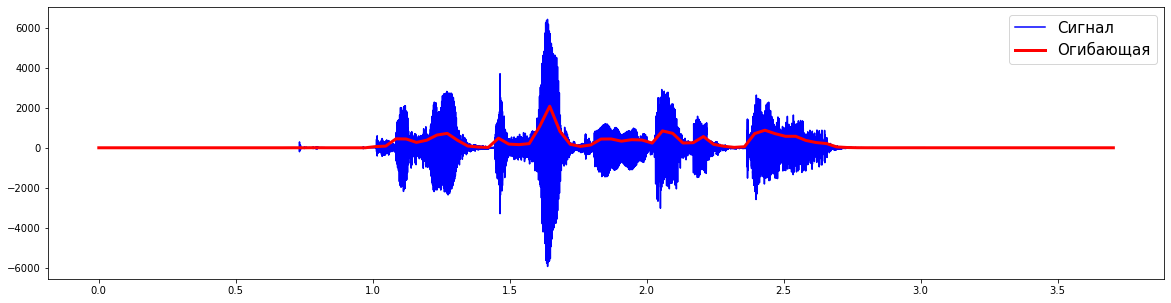

In [6]:
rate, data = wavfile.read("03-01-05-01-01-01-04_A4.wav")

n = 100
m = len(data) // n
envelope = [] 

for j in range(n):
    counter = 0
    for k in range(m * j, m * j + m): 
        counter += abs(data[k])
    envelope.append(counter / m)

plt.figure(figsize=(20, 5))
plt.plot(np.linspace(0, len(data) / rate, num=len(data)), data, color='blue', label='Сигнал')
plt.plot(np.linspace(0, len(data) / rate, num=len(envelope)), envelope, color='red', linewidth=3.0, label='Огибающая')
plt.legend(prop={"size":15})

#### Фильтрация (ФНЧ)
ФНЧ(Фильтр нижниъ частот)- подавляет частоты сигнала выше частоты среза данного фильтра.

Пусть $F_d$ - частота дисеретизации, частота среза - $F_s$, порядок фильтра - $m$. Тогда вычисляем $wn = 2 \frac{F_d}{F_s}$

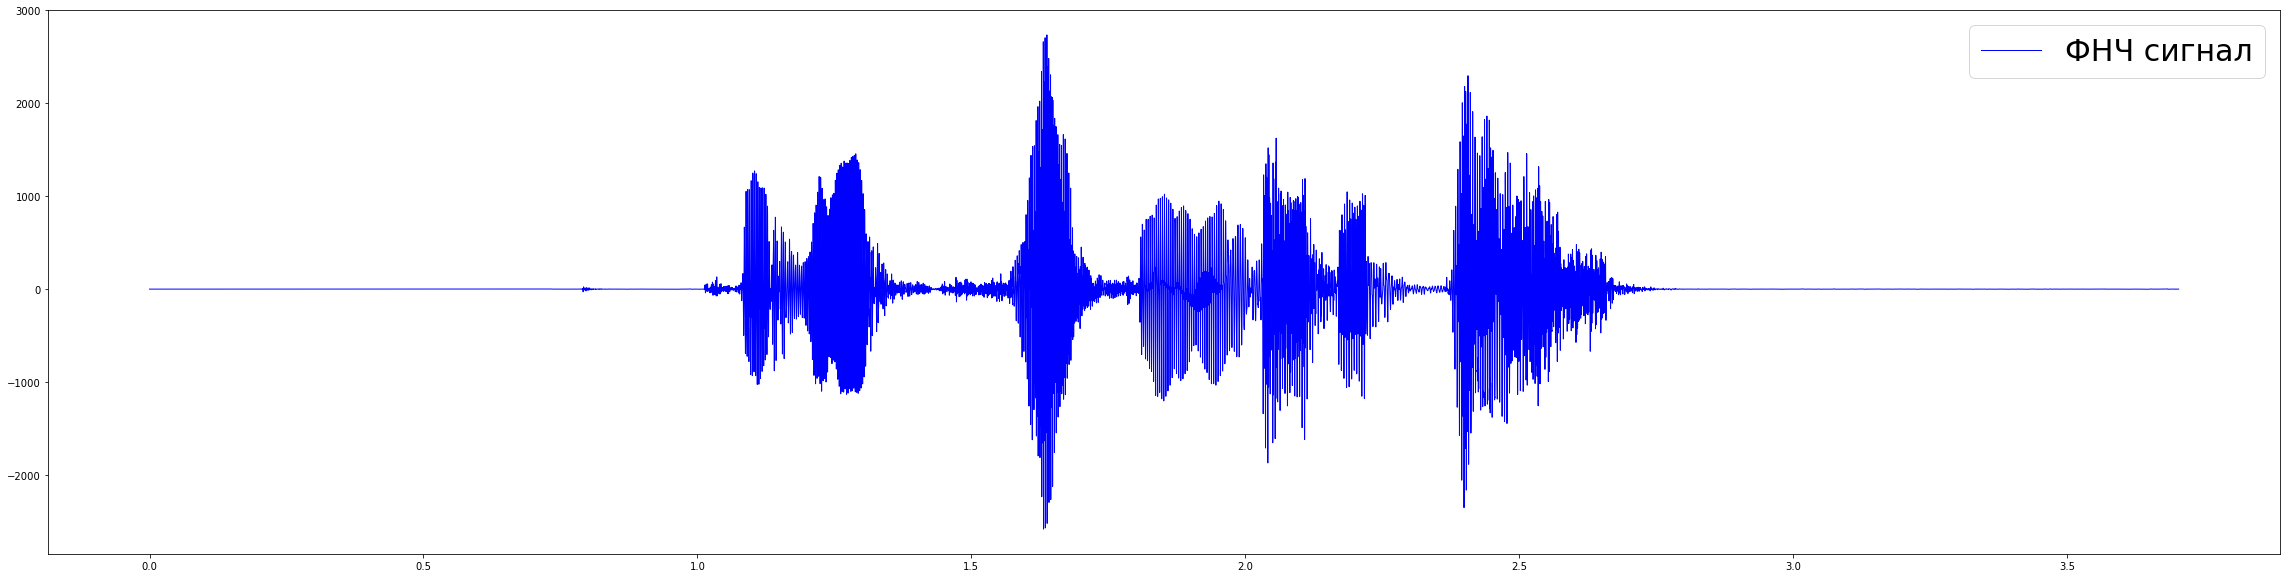

In [7]:
def LPF(_data, F_d):
    m = 2
    F_s = 1000
    wn = 2 * F_s / F_d
    b, a = signal.butter(m, wn, 'lowpass')
    return signal.filtfilt(b, a, _data)

filtedData = LPF(data, rate)
wavfile.write('lowpass.wav', rate, filtedData.astype(np.int16))

plt.figure(figsize=(40, 10))
plt.plot(np.linspace(0, len(data) / rate, num=len(data)), filtedData, color='blue', label='ФНЧ сигнал', linewidth=1)
plt.legend(prop={"size":30})

#### Амплитудный детектор сигнал/шум
Определяем среднее сигнала по амплитуде(без учета знака): $mid = \frac{1}{N}\sum_{k=0}^{N-1}|x(k)|$

Определяем порог детектора — $Th = \alpha ∗mid$, где $0 < \alpha < 1$ подбирается экспериментально.
Задаем величину ”провала”(в отсчетах) — $k$. Обозначим $y(i)$ — сигнал после детектирования.
* **Событие ”начало сигнала”**. Если $x(i)$ в течении $k$ отсчетов превышает порог, $y(i) = x(i)$.

* **Событие ”окончание сигнала”**. Если $x(i)$ в течении $k$ отсчетов меньше порога, $y(i) = 0$

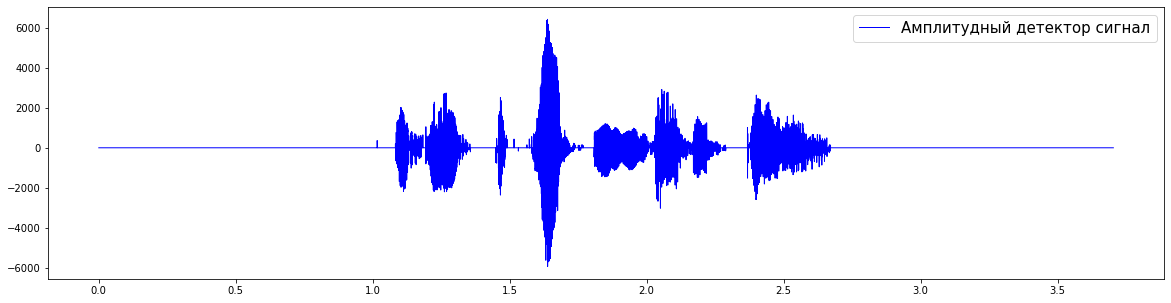

In [8]:
mid = sum([abs(i) for i in data])/len(data)
Th = 0.5 * mid
k = 15
y = np.zeros(len(data))
count_B = 0
count_E = 0

for i in range(len(data)):
    if abs(data[i]) > Th:
        count_B += 1
        count_E = 0
        if count_B >= k:
            y[i] = data[i]
    else:
        count_E += 1
        count_B = 0
        
wavfile.write('detected.wav', rate, y.astype(np.int16))

plt.figure(figsize=(20, 5))
plt.plot(np.linspace(0, len(data) / rate, num=len(data)), y, color='blue', label='Амплитудный детектор сигнал', linewidth=1)
plt.legend(prop={"size":15})

#### Эхо (простейший ревербератор)
$\ \bullet$ Ревебратор реализован, как набор линий задержки. Число линий задержки $N_L > 8$. 
Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): $ \alpha_1 > \alpha _2 > ... > \alpha N_L $

$\ \bullet$ Перед добавлением к исходному сигналу, выход ревебратора фильтруется ФНЧ-фильтром первого порядка.

$\ \bullet$ Желаемое соотношение между "сухим" и обработанным сигналом задается коэффициентом примеримости $\gamma$

$\ \bullet$ Ревебратор может работать в двух режимах: ручной и с использованием готовой конфигурации (present). Для ручного режима, регулируемого пользователем, задается максимальная задержка $D_1$, а величины остальеых определяются автоматически через нее: $D_i = D_1 2^\frac{1-i}{N_L}, i = 2,...,N_L$. Для готовой конфигурации пользователь вручную задает последовательность
$D_1 > D_2 > ... > D_F$, где $F = N_L$

Начальное значение D_1 определяется геометрией помещения, и является расстоянием, пройденным звуком (скорость 335 м/сек) от точки излучения до ближайшего препятствия.

In [9]:
dist = 20.0 / 335.0
speed = 335 #скорость звука
g = 0.7
N_l = 8
D = [0] * N_l
a = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

D[0] = dist
for i in range(1, N_l):
    D[i] = D[0] * pow(2, (1-i)/N_l)

procData = np.zeros(int((np.sum(D) + len(data) / rate + 1) * rate))
for i in range(len(data) -1):
    counter = 0
    for j in range(N_l):
        counter += D[j]
        procData[i + int(counter * rate)] += data[i] * a[j]
        
echo = LPF(procData, rate) * g

for i in range(len(data)):
    echo[i] += data[i]

wavfile.write('echo.wav', rate, echo.astype(np.int16))

#### Классический Distortion (опционально)
Обозначим входной сигнал и выходной сигнал, соответственно как $x(i)$ и $y(i)i = 0,1...,N-1$. Пользователь задает порог - $Th$ и максимальное значение сигнала $Max > Th$. Тогда $Y(i) = \begin{cases}x(i), & |x(i)| \leqslant Th\\Max*sign(x(i)), & |x(i)| > Th\end{cases}$ 

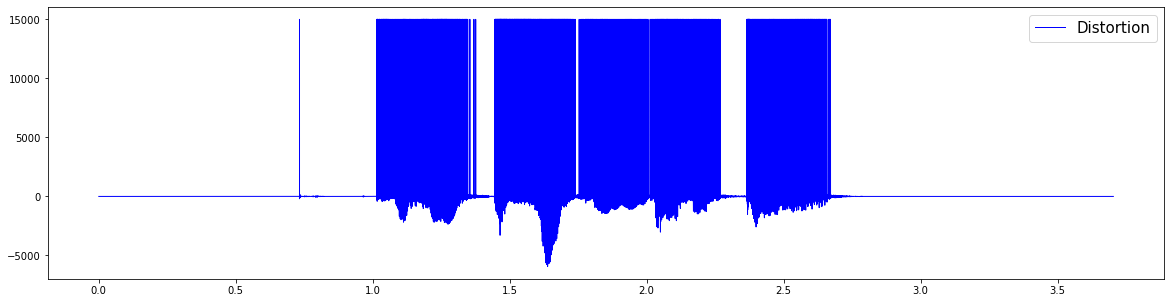

In [10]:
y = np.zeros(len(data))
Th = 150
Max = 15000 

for i in range(len(data)):
    if abs(data[i] <= Th):
        y[i] = data[i]
    else:
        y[i] = Max * np.sign(data[i])

wavfile.write('distortion.wav', rate, y.astype(np.int16))

plt.figure(figsize=(20, 5))
plt.plot(np.linspace(0, len(data) / rate, num=len(data)), y, color='blue', label='Distortion', linewidth=1)
plt.legend(prop={"size":15})

### Вывод
При выполнении лабораторной работы был изучен новый функционал Jupiter, изучены технологии загрузки аудио сигнала и построения его огибающей, так же были изучены технологии фильтрации, детектора сигнала и эффекта эхо. Дополнительно в работе был изучен эффект "Классический Disturtion". Были изучены и применены на практике такие математические пакеты, как numpy и scipy, которые помогли с работой с файлом формата .wav. 